# Simple Wall Shear Stress Visualizer

This notebook focuses only on loading and visualizing Wall Shear Stress (WSS) from aneurysm simulation data.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

In [2]:
# Define the base directory and locate the data
base_dir = Path.cwd()

# Define the directory for aneurysm simulation results
# Try multiple possible locations
possible_paths = [
    base_dir / '../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh',
    base_dir / 'results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh',
    base_dir / '../simulation_output/aneurysm_flow'
]

# Find the first path that exists
aneurysm_folder = None
for path in possible_paths:
    if path.exists():
        aneurysm_folder = path
        break

if aneurysm_folder is None:
    print("Could not find aneurysm data folder. Please provide the correct path:")
    aneurysm_folder = input("Enter the path to aneurysm data: ")
    aneurysm_folder = Path(aneurysm_folder)

print(f"Using aneurysm data from: {aneurysm_folder}")

# Path to the parameter file and processed data directory
param_file = aneurysm_folder / 'parameters' / 'aneurysm_params.json'
processed_dir = aneurysm_folder / 'processed_data' / 'raw_fields'

Using aneurysm data from: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh


In [3]:
# Load simulation parameters
if param_file.exists():
    try:
        with open(param_file, 'r') as f:
            params = json.load(f)
        
        # Extract key simulation parameters
        dt = params['input_parameters'].get('dt', 1e-5)  # Default if not found
        dx = params['input_parameters'].get('dx', 2e-5)  # Default if not found
        print(f"Loaded parameters: dt={dt}, dx={dx}")
    except Exception as e:
        print(f"Error loading parameters: {e}")
        dt = 1e-5  # Default value
        dx = 2e-5  # Default value
else:
    print("Parameter file not found. Using default values.")
    dt = 1e-5  # Default value
    dx = 2e-5  # Default value

Loaded parameters: dt=1e-05, dx=2e-05


In [4]:
# Define paths to the required WSS files
wss_files = {
    'wss_x': processed_dir / 'wss_x.npz',
    'wss_y': processed_dir / 'wss_y.npz',
    'wss_magnitude': processed_dir / 'wss_magnitude.npz'
}

# Check if required files exist
for name, path in wss_files.items():
    if path.exists():
        print(f"✓ {name} file found")
    else:
        print(f"✗ {name} file not found at {path}")

✓ wss_x file found
✓ wss_y file found
✓ wss_magnitude file found


In [5]:
# Load the WSS data (first frame only)
try:
    # Load WSS components
    wss_x = np.load(wss_files['wss_x'])['data'][0]  # First frame only
    wss_y = np.load(wss_files['wss_y'])['data'][0]  # First frame only
    
    # Load or calculate WSS magnitude
    if wss_files['wss_magnitude'].exists():
        wss_magnitude = np.load(wss_files['wss_magnitude'])['data'][0]  # First frame only
    else:
        wss_magnitude = np.sqrt(wss_x**2 + wss_y**2)
    
    print("Successfully loaded WSS data from first frame")
    print(f"WSS magnitude range: [{wss_magnitude.min():.6f}, {wss_magnitude.max():.6f}]")
    print(f"WSS magnitude shape: {wss_magnitude.shape}")
except Exception as e:
    print(f"Error loading WSS data: {e}")
    import traceback
    traceback.print_exc()

Successfully loaded WSS data from first frame
WSS magnitude range: [0.000000, 7.005579]
WSS magnitude shape: (530, 751)


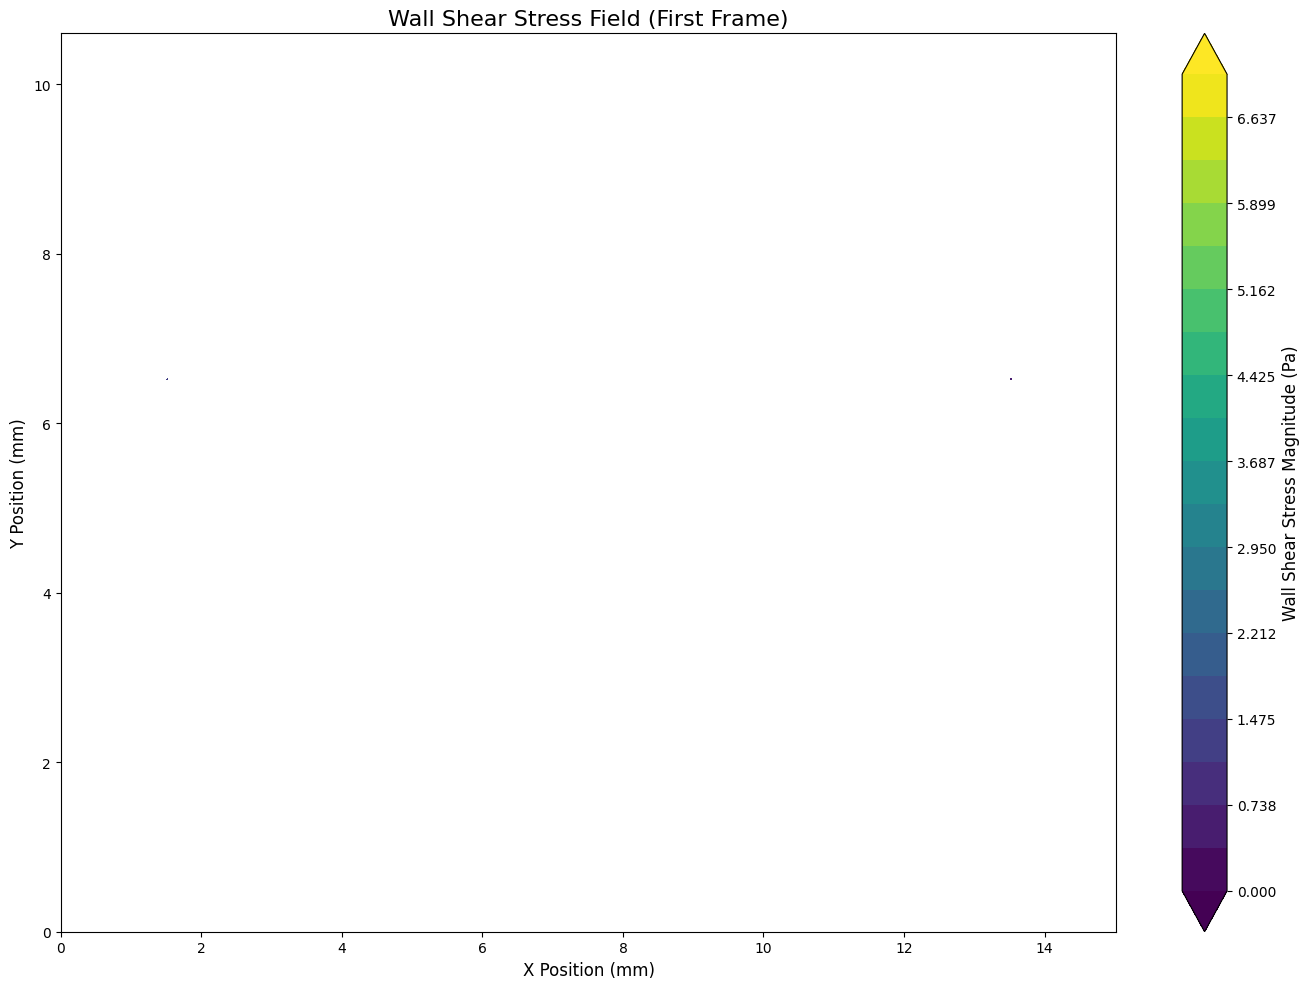

WSS Statistics for non-zero values:
Mean WSS: 0.171697 Pa
Max WSS: 7.005579 Pa
Min WSS: 0.003376 Pa
Number of non-zero WSS points: 1618


In [6]:
# Visualize WSS as a field with contour plot
plt.figure(figsize=(14, 10))

# Get domain dimensions in physical units (mm)
ny, nx = wss_magnitude.shape
x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
extent_mm = [0, max(x_mm), 0, max(y_mm)]

# Create a threshold for visualization
threshold = 0.0001
wss_thresholded = np.where(wss_magnitude > threshold, wss_magnitude, np.nan)

# Create axes for the plot
ax = plt.subplot(1, 1, 1)

# Contour levels for better field visualization
max_wss = np.nanmax(wss_thresholded)
levels = np.linspace(threshold, max_wss, 20)

# Create a filled contour plot for the WSS field
contourf = ax.contourf(x_mm, y_mm, wss_thresholded, levels=levels, cmap='viridis', extend='both')

# Add contour lines with labels for clearer visualization
contour = ax.contour(x_mm, y_mm, wss_thresholded, levels=5, colors='white', alpha=0.5, linewidths=0.5)
plt.clabel(contour, inline=True, fontsize=8, fmt='%.2f')

# Add colorbar
cbar = plt.colorbar(contourf)
cbar.set_label('Wall Shear Stress Magnitude (Pa)', fontsize=12)

# Add title and labels
plt.title('Wall Shear Stress Field (First Frame)', fontsize=16)
plt.xlabel('X Position (mm)', fontsize=12)
plt.ylabel('Y Position (mm)', fontsize=12)

# Add streamlines to show WSS direction
X_mm, Y_mm = np.meshgrid(x_mm, y_mm)
wss_x_masked = np.where(wss_magnitude > threshold, wss_x, 0)
wss_y_masked = np.where(wss_magnitude > threshold, wss_y, 0)

# Add streamlines with color based on magnitude
streamplot = ax.streamplot(x_mm, y_mm, wss_x_masked, wss_y_masked, density=1.5,
                         color=wss_thresholded, cmap='plasma',
                         linewidth=1, arrowsize=1.2)

plt.tight_layout()
plt.show()

# Calculate statistics for non-zero values
non_zero_wss = wss_magnitude[wss_magnitude > threshold]
if len(non_zero_wss) > 0:
    print(f"WSS Statistics for non-zero values:")
    print(f"Mean WSS: {np.mean(non_zero_wss):.6f} Pa")
    print(f"Max WSS: {np.max(non_zero_wss):.6f} Pa")
    print(f"Min WSS: {np.min(non_zero_wss):.6f} Pa")
    print(f"Number of non-zero WSS points: {len(non_zero_wss)}")

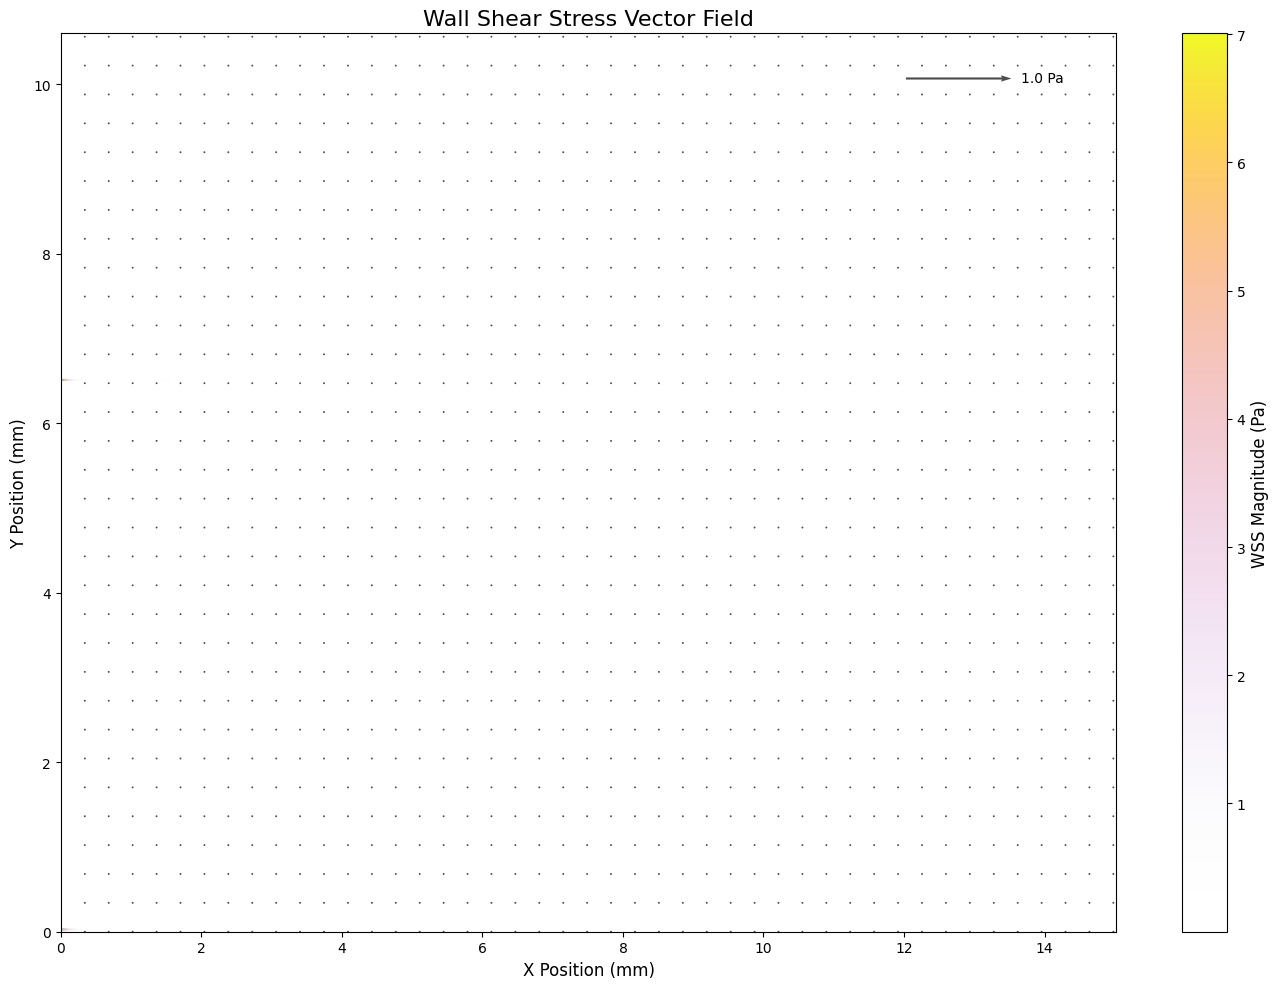

In [7]:
# Alternative visualization showing WSS as a vector field with magnitude
fig, ax = plt.subplots(figsize=(14, 10))

# Create a custom colormap that makes low values transparent
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Define colormap with transparency for low values
colors = plt.cm.plasma(np.linspace(0, 1, 256))
colors[:, 3] = np.linspace(0, 1, 256)**2  # Alpha channel increases quadratically
wss_cmap = LinearSegmentedColormap.from_list('wss_cmap', colors)

# Create background image - a custom field visualization of WSS
field_image = np.zeros((ny, nx, 4))  # RGBA image

# Normalize WSS magnitude for color mapping
norm = Normalize(vmin=threshold, vmax=np.nanmax(wss_thresholded))
sm = ScalarMappable(norm=norm, cmap=wss_cmap)

# Create a field visualization by coloring each point based on WSS magnitude
for i in range(ny):
    for j in range(nx):
        if wss_magnitude[i, j] > threshold:
            rgba = sm.to_rgba(wss_magnitude[i, j])
            field_image[i, j] = rgba
        else:
            field_image[i, j] = [0, 0, 0, 0]  # Transparent

# Display the WSS field image
ax.imshow(field_image, origin='lower', extent=extent_mm, aspect='auto')

# Add quiver plot for vector visualization
skip = max(1, min(nx, ny) // 30)  # Downsample for clarity
quiver = ax.quiver(X_mm[::skip, ::skip], Y_mm[::skip, ::skip],
                   wss_x_masked[::skip, ::skip], wss_y_masked[::skip, ::skip],
                   scale=10, width=0.002, color='black', alpha=0.7)

# Add quiver key for scale reference
ax.quiverkey(quiver, 0.9, 0.95, 1.0, r'1.0 Pa', labelpos='E', color='black')

# Add colorbar - fix by specifying the axis to use
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('WSS Magnitude (Pa)', fontsize=12)

# Add title and labels
ax.set_title('Wall Shear Stress Vector Field', fontsize=16)
ax.set_xlabel('X Position (mm)', fontsize=12)
ax.set_ylabel('Y Position (mm)', fontsize=12)

plt.tight_layout()
plt.show()

Target time: 0.35s (using frame 35)
Total available frames: 101
Successfully loaded WSS data for frame 35 (t=0.35s)
WSS magnitude range: [0.000000, 10.330246]
WSS magnitude shape: (530, 751)


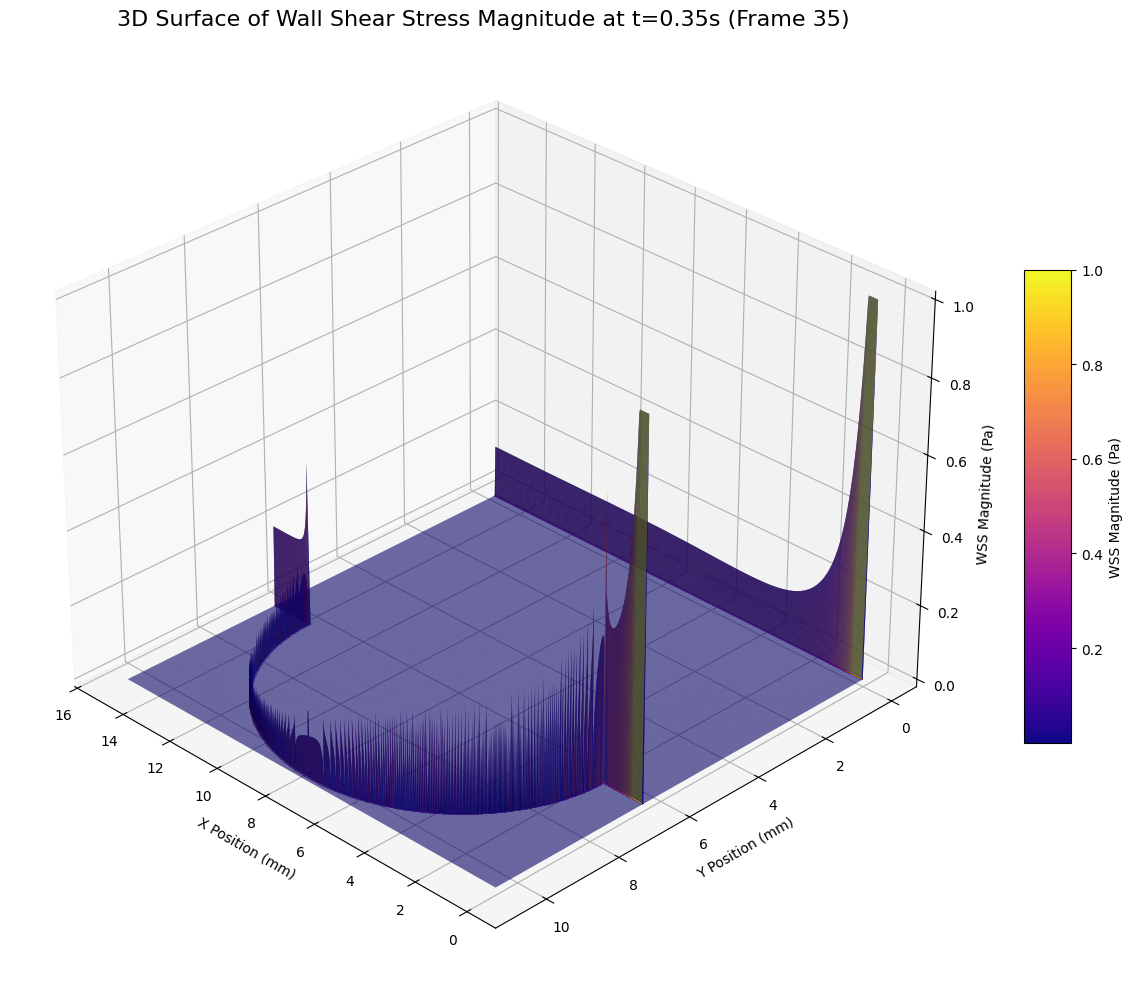


WSS Statistics at t=0.35s (Frame 35) for non-zero values:
Mean WSS: 0.241687 Pa
Max WSS: 10.330246 Pa (capped at 1.0 Pa)
Min WSS: 0.047617 Pa
Number of non-zero WSS points: 1618
Number of points above 1.0 Pa (capped): 36


In [18]:
# Load the complete WSS data (all frames)
try:
    # Load all frames
    wss_x_all = np.load(wss_files['wss_x'])
    wss_y_all = np.load(wss_files['wss_y'])
    
    # Get frame data 
    wss_x_data = wss_x_all['data']
    wss_y_data = wss_y_all['data']
    
    # Set target time and directly use frame 35
    target_time = 0.35  # seconds
    frame_idx = 35      # Directly using frame 35 for t=0.35s
    
    # Get actual frame number if frame_numbers is available
    if 'frame_numbers' in wss_x_all:
        frame_numbers = wss_x_all['frame_numbers']
        actual_frame = frame_numbers[frame_idx] if frame_idx < len(frame_numbers) else None
    else:
        frame_numbers = np.arange(len(wss_x_data))
        actual_frame = frame_idx
    
    # Make sure the frame index is valid
    if frame_idx >= len(wss_x_data):
        print(f"Warning: Frame 35 is out of range. Total frames: {len(wss_x_data)}")
        frame_idx = len(wss_x_data) - 1
    
    print(f"Target time: {target_time}s (using frame {frame_idx})")
    print(f"Total available frames: {len(wss_x_data)}")
    
    # Extract WSS components for frame 35
    wss_x = wss_x_data[frame_idx]
    wss_y = wss_y_data[frame_idx]
    
    # Calculate or load WSS magnitude
    if wss_files['wss_magnitude'].exists():
        wss_magnitude_all = np.load(wss_files['wss_magnitude'])
        wss_magnitude = wss_magnitude_all['data'][frame_idx]
    else:
        wss_magnitude = np.sqrt(wss_x**2 + wss_y**2)
    
    print(f"Successfully loaded WSS data for frame {frame_idx} (t={target_time}s)")
    print(f"WSS magnitude range: [{wss_magnitude.min():.6f}, {wss_magnitude.max():.6f}]")
    print(f"WSS magnitude shape: {wss_magnitude.shape}")
    
except Exception as e:
    print(f"Error loading WSS data: {e}")
    import traceback
    traceback.print_exc()

# Create threshold for visualization
threshold = 0.0001
wss_thresholded = np.where(wss_magnitude > threshold, wss_magnitude, np.nan)

# Get domain dimensions in physical units (mm)
ny, nx = wss_magnitude.shape
x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm

# Create a normalization for the colormap
norm = Normalize(vmin=threshold, vmax=np.nanmax(wss_thresholded))

# Create 3D surface visualization of WSS magnitude at t=0.35
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

# Cap WSS values at 1 Pa
max_wss_threshold = 1.0  # Maximum WSS value in Pa
wss_capped = np.copy(wss_magnitude)
wss_capped[wss_capped > max_wss_threshold] = max_wss_threshold

# Create threshold for visualization
min_threshold = 0.0001
wss_thresholded = np.where(wss_capped > min_threshold, wss_capped, np.nan)

# Create a normalization for the colormap - fixed to use min and max thresholds
norm = Normalize(vmin=min_threshold, vmax=max_wss_threshold)

# Create the figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Prepare grid for 3D surface
X, Y = np.meshgrid(x_mm, y_mm)
Z = wss_capped

# Create mask for non-zero WSS values
mask = Z > min_threshold

# Plot 3D surface with proper normalization
surf = ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.8,
                     rstride=1, cstride=1, 
                     facecolors=plt.cm.plasma(norm(Z)),
                     linewidth=0, antialiased=True, shade=True)

# Add a base contour plot
cset = ax.contourf(X, Y, Z, zdir='z', offset=0, cmap='plasma', alpha=0.5, 
                  levels=np.linspace(min_threshold, max_wss_threshold, 10))

# Set labels and title
ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')
ax.set_zlabel('WSS Magnitude (Pa)')
ax.set_title(f'3D Surface of Wall Shear Stress Magnitude at t=0.35s (Frame 35)', fontsize=16)

# Adjust view angle for better visualization
ax.view_init(elev=30, azim=135)

# Create a ScalarMappable with the same colormap and normalization as the surface
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])  # Dummy array for the colorbar

# Add colorbar linked to the scalar mappable
cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('WSS Magnitude (Pa)')

plt.tight_layout()
plt.show()

# Calculate statistics for non-zero values at this time point (using original data)
non_zero_wss = wss_magnitude[wss_magnitude > min_threshold]
capped_count = np.sum(wss_magnitude > max_wss_threshold)

if len(non_zero_wss) > 0:
    print(f"\nWSS Statistics at t=0.35s (Frame 35) for non-zero values:")
    print(f"Mean WSS: {np.mean(non_zero_wss):.6f} Pa")
    print(f"Max WSS: {np.max(non_zero_wss):.6f} Pa (capped at {max_wss_threshold} Pa)")
    print(f"Min WSS: {np.min(non_zero_wss):.6f} Pa")
    print(f"Number of non-zero WSS points: {len(non_zero_wss)}")
    print(f"Number of points above {max_wss_threshold} Pa (capped): {capped_count}")